# STA 141B Assignment 4

Due __March 8, 2024__ by __11:59pm__. Submit your work by uploading it to Gradescope through Canvas.

Instructions:

1. Provide your solutions in new cells following each exercise description. Create as many new cells as necessary. Use code cells for your Python scripts and Markdown cells for explanatory text or answers to non-coding questions. Answer all textual questions in complete sentences.
2. The use of assistive tools is permitted, but must be indicated. You will be graded on you proficiency in coding. Produce high quality code by adhering to proper programming principles. 
3. Export the .jpynb as .pdf and submit it on Gradescope in time. To facilitate grading, indicate the area of the solution on the submission. Submissions without indication will be marked down. No late submissions accepted. 
4. If test cases are given, your solution must be in the same format. 
5. The total number of points is 10. 

__(a, i)__ Write a function that retrieves all links to movies in the database by scraping the _alphabetical_ section on [imsdb.com](https://imsdb.com/) and retrieve the links. _How many links did you find?_ __(ii)__ Write a function `fetch_script` that, given the link of a movie retrieved in (i), returns a dictionary that contains all relevant information of the movie: 

```python
fetch_script('/Movie Scripts/10 Things I Hate About You Script.html')

>>> {'title': '10 Things I Hate About You',
     'writers': ['Karen McCullah Lutz', 'Kirsten Smith', 'William Shakespeare'],
     'genres': ['Comedy', 'Romance'],
     'date': 1997,
     'script': '...'}
```

The `script` field contains a string of the scraped script. Retrieve the information for all movies. _How many scripts did you retrieve?_

In [2]:
import requests
import requests_cache
import lxml.html as lx
import re

In [3]:
###Testing x paths
curr_link = 'https://imsdb.com/Movie%20Scripts/8%20Mile%20Script.html'
response = requests.get(curr_link)
page = lx.fromstring(response.text)
movie_script_link = page.xpath('//table[@class = "script-details"]//tr[2]/td[2]//a[last()]/@href')
# script_page = lx.fromstring(requests.get('https://imsdb.com' + movie_script_link[0]).text)
# print(script_page.xpath('//*[@class = "scrtext"]/pre[1]//*/text()'))
script_page = lx.fromstring(requests.get('https://imsdb.com' + movie_script_link[0]).text)
script_page.xpath('//*[@class = "scrtext"]//text()')
print(movie_script_link)

['/scripts/8-Mile.pdf']


In [4]:
requests_cache.install_cache("imdb_cache")
def fetch_movie_links():
    link_template = 'https://imsdb.com/alphabetical/'
    curr_link = ''
    movie_links = []
    for i in range(64,91):
        if i == 64:
            curr_link = link_template + '0'
        else:
            curr_link = link_template + chr(i)
        response = requests.get(curr_link)
        page = lx.fromstring(response.text)
        page_links = page.xpath('//td/p//@href')
        page_links = [link.replace(' ', '%20') for link in page_links]
        [movie_links.append('https://imsdb.com' + i) for i in page_links]
    return movie_links
total = fetch_movie_links()
len(total)
        

1221

In [5]:
def fetch_script(link): 
    movie_info = {'title': None, 'writers': None, 'genres': None, 'date': None, 'script': None}
    response = requests.get(link)
    page = lx.fromstring(response.text)
    movie_info['title'] = page.xpath('//table[@class = "script-details"]//tr[1]/td/h1/text()')[0].replace(' Script', '') #Get title
    movie_info['writers'] = page.xpath('//table[@class = "script-details"]//tr[2]/td[2]/a[following-sibling::b[contains(text(), "Genres")]]/text()')
    movie_info['genres'] = page.xpath('//table[@class = "script-details"]//tr[2]/td[2]/a[preceding-sibling::b[contains(text(), "Genres")] and following-sibling::b[contains(text(), "Date")]]/text()')
    date = page.xpath('//table[@class="script-details"]//tr[2]/td[2]//b[contains(text(), "Date")]/following-sibling::text()[1]')
    if date:
        date = date[0].replace(' : ', '')
    movie_info['date'] = date
    movie_script_link = page.xpath('//table[@class = "script-details"]//tr[2]/td[2]//a[last()]/@href')
    if movie_script_link:
        script_page = lx.fromstring(requests.get('https://imsdb.com' + movie_script_link[0]).text)
        movie_info['script'] = script_page.xpath('//*[@class = "scrtext"]//text()')
    else:
        movie_info['script'] = movie_script_link
    return movie_info
    

In [5]:
fetch_script('https://imsdb.com/Movie%20Scripts/8%20Mile%20Script.html')['genres']

['Drama', 'Musical']

In [ ]:
requests_cache.install_cache("imdb_cache")
counter = 0
for link in total:
    movie_info = fetch_script(link)
    if movie_info['script'] != []:
        counter += 1
counter

__(b)__ We are interested in the genres `'Musical'`, `'Horror'`, and `'Romance'`. Craft a barplot displaying the absolute counts for each of these categories. In each bar, color-code the movies that are also counted in the other two genres. 

In [28]:
requests_cache.install_cache("imdb_cache")
genre_df = pd.DataFrame(columns=['Movie', 'Musical', 'Horror', 'Romance'])
counter = 0
for link in total:
    curr_movie = fetch_script(link)
    curr_movie_genres = curr_movie['genres']
    curr_movie_info = {'Movie': curr_movie['title'], 'Musical': 0, 'Horror': 0, 'Romance': 0}
    for genre in curr_movie_genres:
        if genre in ['Musical', 'Horror', 'Romance']:
            curr_movie_info[genre] = 1
    genre_df.loc[counter] = curr_movie_info
    counter += 1
genre_df.set_index('Movie', inplace=True)
genre_df

,Musical,Horror,Romance
Movie,,,
10 Things I Hate About You,0,0,1
12,0,0,0
12 and Holding,0,0,0
12 Monkeys,0,0,0
12 Years a Slave,0,0,0
...,...,...,...
You've Got Mail,0,0,1
Youth in Revolt,0,0,1
Zero Dark Thirty,0,0,0


In [29]:
genre_counts = genre_df.sum()
genre_counts

Musical     26
Horror     124
Romance    180
dtype: int64

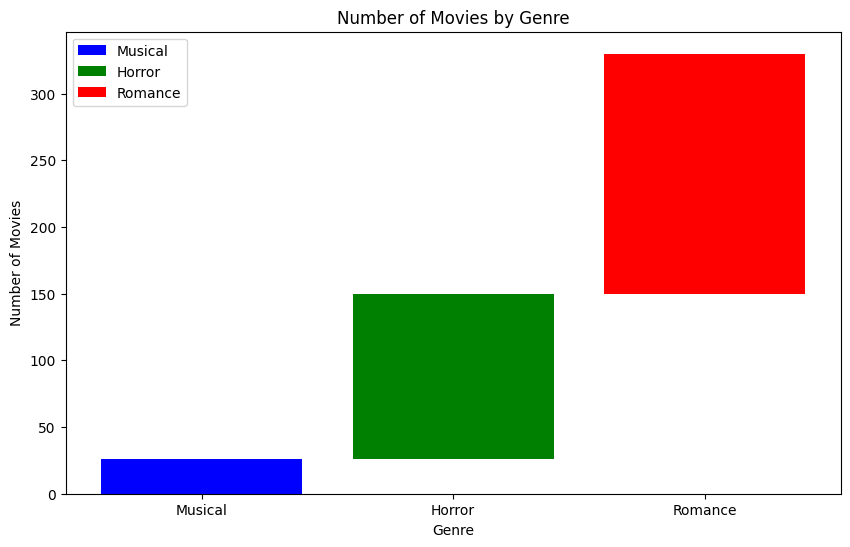

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
bottom = None
colors = ['blue', 'green', 'red']

for i, genre in enumerate(genre_counts.index):
    counts = genre_df[genre_df[genre] == 1].count()
    plt.bar(genre, counts[genre], bottom=bottom, color=colors[i])
    if bottom is None:
        bottom = counts[genre]
    else:
        bottom += counts[genre]

plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Genre')
plt.legend(genre_counts.index)
plt.show()

__(c, i)__ Using only regex, write a function `tokenizer` that returns bigrams of all non-whitespace and non-punctuation characters, according to the test case below: 

```python
test = '''
    Neque porro quisquam est, qui dolorem ipsum quia dolor sit amet, 
    consectetur, adipisci velit, sed quia non numquam eius modi tempora 
    incidunt ut labore et dolore magnam aliquam quaerat voluptatem.
'''
tokenizer(test)
>>> ['neque porro',
 'porro quisquam',
 'quisquam est',
 'qui dolorem',
 'dolorem ipsum',
 'ipsum quia',
 'quia dolor',
 'dolor sit',
 'sit amet',
 'adipisci velit',
 'sed quia',
 'quia non',
 'non numquam',
 'numquam eius',
 'eius modi',
 'modi tempora',
 'incidunt ut',
 'ut labore',
 'labore et',
 'et dolore',
 'dolore magnam',
 'magnam aliquam',
 'aliquam quaerat',
 'quaerat voluptatem']
 ```

In [49]:
import re

def tokenizer(text):
    text = re.sub(r'\n|\s{2,}|[^\w\s]','', text.lower())
    bigram = []
    match = re.match(r'\b(\w+\s+\w+)\b', text)
    if match:
        first_word_len = len(re.match(r'\b(\w+)\b', text).group(1))
        bigram.append(match.group(1))
        bigram.extend(tokenizer(text[first_word_len+1:]))
    return bigram

In [42]:
text = ''
text = re.sub(r'\n|\s{2,}|[^\w\s]','', text.lower())
if not re.match(r'\b(\w+\s+\w+)\b', text):
    print(1)

1


In [50]:
test = '''
    Neque porro quisquam est, qui dolorem ipsum quia dolor sit amet, 
    consectetur, adipisci velit, sed quia non numquam eius modi tempora 
    incidunt ut labore et dolore magnam aliquam quaerat voluptatem.
'''
tokenizer(test)

['neque porro',
 'porro quisquam',
 'quisquam est',
 'est qui',
 'qui dolorem',
 'dolorem ipsum',
 'ipsum quia',
 'quia dolor',
 'dolor sit',
 'sit ametconsectetur',
 'ametconsectetur adipisci',
 'adipisci velit',
 'velit sed',
 'sed quia',
 'quia non',
 'non numquam',
 'numquam eius',
 'eius modi',
 'modi temporaincidunt',
 'temporaincidunt ut',
 'ut labore',
 'labore et',
 'et dolore',
 'dolore magnam',
 'magnam aliquam',
 'aliquam quaerat',
 'quaerat voluptatem']

In [14]:
test = '''
    Neque porro quisquam est, qui dolorem ipsum quia dolor sit amet, 
    consectetur, adipisci velit, sed quia non numquam eius modi tempora 
    incidunt ut labore et dolore magnam aliquam quaerat voluptatem.
'''
tokenizer(test)

['neque porro',
 'porro quisquam',
 'quisquam est',
 'qui dolorem',
 'dolorem ipsum',
 'ipsum quia',
 'quia dolor',
 'dolor sit',
 'sit amet',
 'adipisci velit',
 'sed quia',
 'quia non',
 'non numquam',
 'numquam eius',
 'eius modi',
 'modi tempora',
 'incidunt ut',
 'ut labore',
 'labore et',
 'et dolore',
 'dolore magnam',
 'magnam aliquam',
 'aliquam quaerat',
 'quaerat voluptatem']

__(ii)__ Use the tokenizer to obtain a tf-idf vector for each movie. Perform a (non-centered) principal component analysis (`sklearn.decomposition.TruncatedSVD`). _What fraction of variation is explained by the first principal component?_ __(iii)__ Generate a strip-plot for the first principal components versus all three genres. Does visualization indicate that a good classification could result from this approach? 